In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

### Data

In [2]:
data_path = '/Users/maxim_anisimov/Desktop/GitHub/data/'

cpi_path = 'global-economic-monitor/Core CPI, seas. adj..xlsx'
cpi = pd.read_excel(data_path+cpi_path, sheet_name='monthly', index_col=0, parse_dates=True)
cpi_us = cpi[['United States']]
cpi_growth_us = cpi_us.pct_change()

# exchange_rate_path = 'global-economic-monitor/Exchange rate, new LCU per USD extended backward, period average.xlsx'
# exchange_rate = pd.read_excel(data_path+exchange_rate_path, sheet_name='monthly', index_col=0, parse_dates=True)
# exchange_rate_us = exchange_rate[['United States']]

# unemployment_path = 'global-economic-monitor/Unemployment Rate, seas. adj..xlsx'
# unemployment = pd.read_excel(data_path+unemployment_path, sheet_name='monthly', index_col=0, parse_dates=True)
# unemployment_us = unemployment[['United States']]

ind_production_path = 'global-economic-monitor/Industrial Production, constant 2010 US$, seas. adj..xlsx'
ind_production = pd.read_excel(data_path+ind_production_path, sheet_name='monthly', index_col=0, parse_dates=True)
ind_production_us = ind_production[['United States']]
ind_prod_growth_us = ind_production_us.pct_change()

interest_rate_path = 'DGS1.xls' # from St. Loius FED
interest_rate_us = pd.read_excel(data_path+interest_rate_path, skiprows=10, index_col=0, parse_dates=True)
interest_rate_us = interest_rate_us.resample('1M').last() # resample from daily to monthly
interest_rate_us = interest_rate_us[interest_rate_us.index < '2019-06-01']
interest_rate_us.index = ind_prod_growth_us.index[1:]

In [3]:
data_df = pd.concat([cpi_growth_us, ind_prod_growth_us, interest_rate_us], axis=1).dropna()
data_df.columns = ['CPI growth', 'Industrial production growth', 'Interest rate']
n_variables = data_df.shape[1]
n_obs = data_df.shape[0]

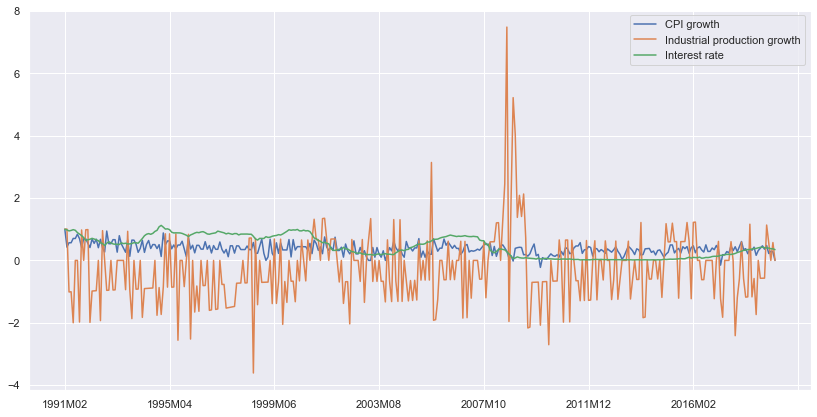

In [4]:
(data_df/data_df.iloc[0,:]).plot(figsize=(14,7));

In [5]:
data = np.asmatrix(data_df)

### Simple VAR

In [6]:
n_lags = 2
include_const = True

# transform data
endog_variables_lst = [data[lag-1:-n_lags+lag-1] for lag in range(1,n_lags+1)][::-1]
X = np.hstack(endog_variables_lst)
if include_const == True:
    X = np.append(np.ones((n_obs-n_lags,1)), X, axis=1)
Y = data[n_lags:]

# OLS estimation
beta_array = np.linalg.inv(X.T @ X) @ X.T @ Y # transpose if you want to premultiply X.T
beta_array

matrix([[ 1.06007528e-03,  1.52514982e-04,  4.90776363e-02],
        [ 8.18738147e-02,  2.64177843e-01, -3.13674354e+00],
        [-4.09705267e-03,  7.60173471e-02,  2.77190854e+00],
        [ 1.31690824e-04,  6.26504703e-03,  1.31160993e+00],
        [ 1.52147938e-01, -1.22091956e-01, -2.02144795e+01],
        [ 6.99007077e-04,  1.52766893e-01,  2.21810425e-01],
        [-8.27967242e-06, -5.92688710e-03, -3.18219956e-01]])

In [7]:
# Forecast 1 period ahead
Y_hat_1 = np.asmatrix(X[-1]) @ np.asmatrix(beta_array)
Y_hat_1

matrix([[1.70634552e-03, 8.28483039e-04, 2.37654944e+00]])

In [8]:
Y[-1]

matrix([[0.  , 0.  , 2.21]])

In [9]:
np.vstack([Y[-1], Y[-2]])

matrix([[ 0.00000000e+00,  0.00000000e+00,  2.21000000e+00],
        [ 1.38099278e-03, -3.38983051e-03,  2.39000000e+00]])

In [10]:
horizon = 5

# create new X for the first forecast horizon
X_new = np.hstack( [Y[-h] for h in range(1,n_lags+1)] ) # # all needed X vectors stacked in a matrix
if include_const:
    X_new = np.append(1, X_new)

X_hat = np.asmatrix(X_new) # since it is a first iteration

# last forecast (here it is number one)
Y_hat_last = np.asmatrix(X_hat[-1]) @ np.asmatrix(beta_array)
Y_hat = np.asmatrix( np.vstack([Y[-n_lags:], Y_hat_last]) )

if horizon > 1:
    for i in range(1, horizon):

        # create new X now using Y_hat
        X_new = np.hstack( [Y_hat[-h] for h in range(1,n_lags+1)] ) # # all needed X vectors stacked in a matrix
        if include_const:
            X_new = np.append(1, X_new)

        X_hat = np.vstack([X_hat, X_new]) # add current X to X_hat

        # forecast using the last X_hat
        Y_hat_last = np.asmatrix(X_hat[-1]) @ np.asmatrix(beta_array)
        Y_hat = np.asmatrix( np.vstack([Y_hat, Y_hat_last]) )

# remove first n_lags Y values since they are not really predicted
Y_hat = Y_hat[n_lags:,:]
    
Y_hat

matrix([[ 1.53906927e-03, -8.53453233e-04,  2.15852193e+00],
        [ 1.45554085e-03,  9.19046652e-04,  2.16975697e+00],
        [ 1.67691545e-03,  1.08892639e-03,  2.17474872e+00],
        [ 1.68343888e-03,  1.40598473e-03,  2.17957889e+00],
        [ 1.71706917e-03,  1.43140957e-03,  2.18074681e+00]])

#### Using statsmodels

In [11]:
var_statsmodel = VAR(data)
result = var_statsmodel.fit(n_lags)

In [12]:
result.coefs_exog # coefs for const

array([[0.00106008],
       [0.00015251],
       [0.04907764]])

In [13]:
result.coefs # coefs for lagged variables

array([[[ 8.18738147e-02, -4.09705267e-03,  1.31690824e-04],
        [ 2.64177843e-01,  7.60173471e-02,  6.26504703e-03],
        [-3.13674354e+00,  2.77190854e+00,  1.31160993e+00]],

       [[ 1.52147938e-01,  6.99007077e-04, -8.27967242e-06],
        [-1.22091956e-01,  1.52766893e-01, -5.92688710e-03],
        [-2.02144795e+01,  2.21810425e-01, -3.18219956e-01]]])

In [14]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, May, 2020
Time:                     19:06:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.2942
Nobs:                     338.000    HQIC:                  -27.4370
Log likelihood:           3235.05    FPE:                1.10446e-12
AIC:                     -27.5317    Det(Omega_mle):     1.03859e-12
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.001060         0.000126            8.432           0.000
L1.y1         0.081874         0.054707            1.497           0.134
L1.y2        -0.004097         0.006925           -0.592           0.554
L1.y3         0.000132

In [15]:
result.forecast(result.y, steps=5)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


array([[ 1.53906927e-03, -8.53453233e-04,  2.15852193e+00],
       [ 1.45554085e-03,  9.19046652e-04,  2.16975697e+00],
       [ 1.67691545e-03,  1.08892639e-03,  2.17474872e+00],
       [ 1.68343888e-03,  1.40598473e-03,  2.17957889e+00],
       [ 1.71706917e-03,  1.43140957e-03,  2.18074681e+00]])

In [16]:
result.coefs_exog + result.coefs[0] @ result.y[-1] + result.coefs[1] @ result.y[-2]

array([[ 1.53906927e-03,  5.41070604e-05,  2.11050437e+00],
       [ 6.31508974e-04, -8.53453233e-04,  2.10959681e+00],
       [ 4.95566303e-02,  4.80716681e-02,  2.15852193e+00]])

### VAR with the 0 prior on coefficients

In [17]:
# OLS estimation
penalty = 10
bias_matrix = penalty*np.identity(X.shape[1])

beta_array_biased = np.linalg.inv(X.T @ X + bias_matrix) @ X.T @ Y
beta_array_biased

matrix([[ 1.28258999e-03,  3.64333906e-04,  2.38070216e-02],
        [ 3.94943273e-06,  3.62101985e-06, -1.20819571e-04],
        [-5.73616183e-06,  1.63438233e-04,  8.45511272e-03],
        [ 8.96931594e-05,  3.37949564e-03,  8.59791455e-01],
        [ 5.42428792e-06, -4.99541700e-06, -5.44668322e-04],
        [-1.69595472e-06,  2.52597869e-04,  4.31367046e-03],
        [ 9.19178361e-05, -2.90708065e-03,  1.26935082e-01]])

In [18]:
# Forecast 1 period ahead
np.asmatrix(X[-1]) @ np.asmatrix(beta_array_biased)

matrix([[1.71759234e-03, 1.46377852e-03, 2.38332317e+00]])

### Creating a class

In [21]:
class VAR_Model():
    """
    Handcrafted VAR model allowing for Ridge penalty.
    """
    
    def __init__(self, data):
        self.data = data
       
    
    def fit(self, n_lags, include_const=True, ridge_penalty=0):
        
        import numpy as np
        
        self.n_lags = n_lags
        self.include_const = include_const
        self.n_variables = data.shape[1] + self.include_const
        self.n_obs = data.shape[0]
        self.ridge_penalty = ridge_penalty
        
        # transform data to X and Y
        endog_variables_lst = [data[lag-1:-n_lags+lag-1] for lag in range(1,n_lags+1)][::-1]
        X = np.hstack(endog_variables_lst)
        if include_const == True:
            X = np.append(np.ones((self.n_obs-n_lags,1)), X, axis=1)
        self.X = X
        Y = data[n_lags:]
        self.Y = Y
        
        # Ridge penalty
        bias_matrix = ridge_penalty*np.identity(X.shape[1])
        
        # OLS estimation
        beta_array = np.linalg.inv(X.T @ X + bias_matrix) @ X.T @ Y
        self.beta_array = beta_array
        
    
    def predict(self, Y, horizon):

        # create new X for the first forecast horizon
        X_new = np.hstack( [Y[-h] for h in range(1,n_lags+1)] ) # # all needed X vectors stacked in a matrix
        if include_const:
            X_new = np.append(1, X_new)

        X_hat = np.asmatrix(X_new) # since it is a first iteration

        # last forecast (here it is number one)
        Y_hat_last = np.asmatrix(X_hat[-1]) @ np.asmatrix(beta_array)
        Y_hat = np.asmatrix( np.vstack([Y[-n_lags:], Y_hat_last]) )

        if horizon > 1:
            for i in range(1, horizon):

                # create new X now using Y_hat
                X_new = np.hstack( [Y_hat[-h] for h in range(1,n_lags+1)] ) # # all needed X vectors stacked in a matrix
                if include_const:
                    X_new = np.append(1, X_new)

                X_hat = np.vstack([X_hat, X_new]) # add current X to X_hat

                # forecast using the last X_hat
                Y_hat_last = np.asmatrix(X_hat[-1]) @ np.asmatrix(beta_array)
                Y_hat = np.asmatrix( np.vstack([Y_hat, Y_hat_last]) )

        # remove first n_lags Y values since they are not really predicted
        Y_hat = Y_hat[n_lags:,:]
                
        return Y_hat
        

In [22]:
var_model = VAR_Model(data)

In [23]:
var_model.fit(2)
var_model.beta_array

matrix([[ 1.06007528e-03,  1.52514982e-04,  4.90776363e-02],
        [ 8.18738147e-02,  2.64177843e-01, -3.13674354e+00],
        [-4.09705267e-03,  7.60173471e-02,  2.77190854e+00],
        [ 1.31690824e-04,  6.26504703e-03,  1.31160993e+00],
        [ 1.52147938e-01, -1.22091956e-01, -2.02144795e+01],
        [ 6.99007077e-04,  1.52766893e-01,  2.21810425e-01],
        [-8.27967242e-06, -5.92688710e-03, -3.18219956e-01]])

In [24]:
predictions = var_model.predict(Y, 100)

In [25]:
predictions[:5]

matrix([[ 1.53906927e-03, -8.53453233e-04,  2.15852193e+00],
        [ 1.45554085e-03,  9.19046652e-04,  2.16975697e+00],
        [ 1.67691545e-03,  1.08892639e-03,  2.17474872e+00],
        [ 1.68343888e-03,  1.40598473e-03,  2.17957889e+00],
        [ 1.71706917e-03,  1.43140957e-03,  2.18074681e+00]])

In [26]:
result.forecast(result.y, steps=5)

array([[ 1.53906927e-03, -8.53453233e-04,  2.15852193e+00],
       [ 1.45554085e-03,  9.19046652e-04,  2.16975697e+00],
       [ 1.67691545e-03,  1.08892639e-03,  2.17474872e+00],
       [ 1.68343888e-03,  1.40598473e-03,  2.17957889e+00],
       [ 1.71706917e-03,  1.43140957e-03,  2.18074681e+00]])

In [30]:
data_df.tail()

,CPI growth,Industrial production growth,Interest rate
2019M01,0.002396,-0.006711,2.55
2019M02,0.001104,-0.003378,2.54
2019M03,0.001475,0.000000,2.40
2019M04,0.001381,-0.003390,2.39
2019M05,0.000000,0.000000,2.21


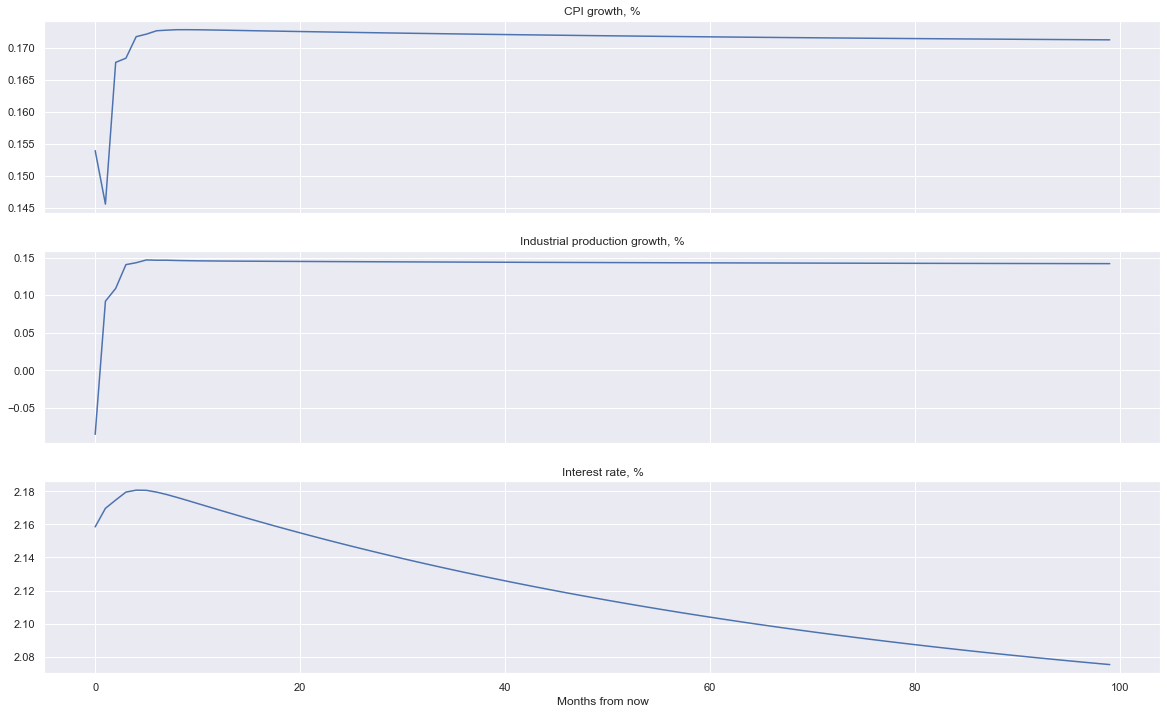

In [35]:
f, axes = plt.subplots(3, 1, sharex=True, figsize=(20,12))
sns.lineplot(x=[*range(predictions.shape[0])], y=100*np.ravel(predictions[:,0]), ax=axes[0])
axes[0].set_title('CPI growth, %')
sns.lineplot(x=[*range(predictions.shape[0])], y=100*np.ravel(predictions[:,1]), ax=axes[1])
axes[1].set_title('Industrial production growth, %')
sns.lineplot(x=[*range(predictions.shape[0])], y=np.ravel(predictions[:,2]), ax=axes[2])
axes[2].set_title('Interest rate, %')
axes[2].set_xlabel('Months from now');